In [1]:
import os, glob, random, shutil
from PIL import Image
import matplotlib.pyplot as plt

cwd = os.getcwd()
PROJECT_ROOT = os.path.dirname(cwd) if os.path.basename(cwd).lower() == "notebooks" else cwd

RAW_DIR  = os.path.join(PROJECT_ROOT, "data_raw")   # <-- your raw class folders live here
DATA_DIR = os.path.join(PROJECT_ROOT, "data")       # <-- will be created (train/val/test)

os.makedirs(DATA_DIR, exist_ok=True)
for s in ["train", "val", "test"]:
    os.makedirs(os.path.join(DATA_DIR, s), exist_ok=True)

print("PROJECT_ROOT:", PROJECT_ROOT)
print("RAW_DIR:", RAW_DIR)
print("DATA_DIR:", DATA_DIR)

# Show which class folders exist in data_raw
raw_classes = [d for d in os.listdir(RAW_DIR) if os.path.isdir(os.path.join(RAW_DIR, d))]
print("Raw classes found:", raw_classes)


PROJECT_ROOT: C:\cv_partb
RAW_DIR: C:\cv_partb\data_raw
DATA_DIR: C:\cv_partb\data
Raw classes found: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_healthy', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_mosaic_virus', 'Tomato__Tomato_YellowLeaf__Curl_Virus']


In [2]:
SELECTED_CLASSES = [
    "Tomato_Bacterial_spot",
    "Tomato_Early_blight",
    "Tomato_Late_blight",
    "Tomato_healthy",
]
SELECTED_CLASSES


['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_healthy']

In [4]:
def make_splits(selected_classes, raw_dir=RAW_DIR, data_dir=DATA_DIR,
                seed=42, train_ratio=0.70, val_ratio=0.15):
    random.seed(seed)
    for cls in selected_classes:
        src = os.path.join(raw_dir, cls)
        if not os.path.isdir(src):
            raise FileNotFoundError(f"Missing folder: {src}")

        imgs = glob.glob(os.path.join(src, "*"))
        imgs = [p for p in imgs if os.path.isfile(p)]
        random.shuffle(imgs)

        n = len(imgs)
        n_train = int(n * train_ratio)
        n_val   = int(n * val_ratio)
        n_test  = n - n_train - n_val

        splits = {
            "train": imgs[:n_train],
            "val":   imgs[n_train:n_train+n_val],
            "test":  imgs[n_train+n_val:],
        }

        for split, paths in splits.items():
            dst = os.path.join(data_dir, split, cls)
            os.makedirs(dst, exist_ok=True)
            for p in paths:
                tgt = os.path.join(dst, os.path.basename(p))
                if not os.path.exists(tgt): 
                    shutil.copy2(p, tgt)

    print("done creating splits at:", data_dir)

make_splits(SELECTED_CLASSES)


done creating splits at: C:\cv_partb\data


In [5]:
def count_split(split_name):
    split_dir = os.path.join(DATA_DIR, split_name)
    counts = {}
    for cls in sorted(os.listdir(split_dir)):
        cls_dir = os.path.join(split_dir, cls)
        if os.path.isdir(cls_dir):
            counts[cls] = len([p for p in glob.glob(os.path.join(cls_dir, "*")) if os.path.isfile(p)])
    return counts

for split in ["train", "val", "test"]:
    print(f"\n--- {split.upper()} ---")
    for cls, n in count_split(split).items():
        print(f"{cls}: {n}")



--- TRAIN ---
Tomato_Bacterial_spot: 1488
Tomato_Early_blight: 700
Tomato_Late_blight: 1336
Tomato_healthy: 1113

--- VAL ---
Tomato_Bacterial_spot: 319
Tomato_Early_blight: 150
Tomato_Late_blight: 286
Tomato_healthy: 238

--- TEST ---
Tomato_Bacterial_spot: 320
Tomato_Early_blight: 150
Tomato_Late_blight: 287
Tomato_healthy: 240


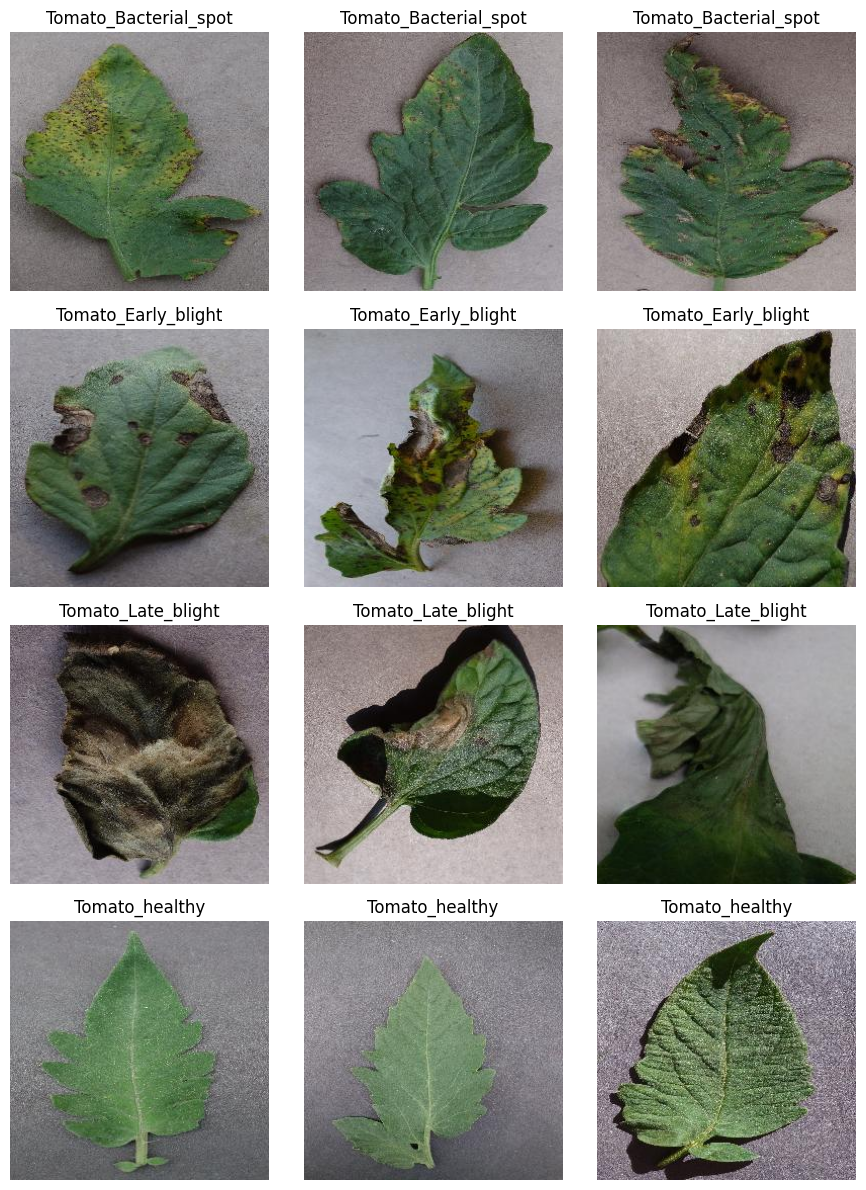

In [6]:
import math, random

def show_samples(split="train", per_class=3):
    split_dir = os.path.join(DATA_DIR, split)
    classes = [c for c in sorted(os.listdir(split_dir)) if os.path.isdir(os.path.join(split_dir, c))]
    if not classes:
        print("No classes found in", split_dir)
        return

    nrows = len(classes)
    ncols = per_class
    fig, axes = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows))
    if nrows == 1:
        axes = [axes]  # ensure 2D-like indexing for single row

    for i, cls in enumerate(classes):
        files = [p for p in glob.glob(os.path.join(split_dir, cls, "*")) if os.path.isfile(p)]
        random.shuffle(files)
        show_files = files[:per_class]
        for j in range(per_class):
            ax = axes[i][j] if ncols > 1 else axes[i][0]
            if j < len(show_files):
                img = Image.open(show_files[j]).convert("RGB")
                ax.imshow(img)
                ax.set_title(cls)
            ax.axis("off")

    plt.tight_layout()
    plt.show()

show_samples("train", per_class=3)


In [7]:
summary_txt = os.path.join(PROJECT_ROOT, "outputs", "metrics", "data_summary.txt")
os.makedirs(os.path.dirname(summary_txt), exist_ok=True)

lines = []
for split in ["train", "val", "test"]:
    lines.append(f"== {split.upper()} ==")
    for cls, n in count_split(split).items():
        lines.append(f"{cls}: {n}")
    lines.append("")

with open(summary_txt, "w", encoding="utf-8") as f:
    f.write("\n".join(lines))

print("Saved summary to:", summary_txt)


Saved summary to: C:\cv_partb\outputs\metrics\data_summary.txt


In [8]:
import os, sys
from PIL import Image

DATA_DIR = os.path.join(PROJECT_ROOT, "data")  # adjust if needed
VALID_EXTS = {".jpg", ".jpeg", ".png", ".bmp"}

bad_files = []

def is_image_ok(path):
    try:
        if os.path.getsize(path) == 0:
            return False
        ext = os.path.splitext(path)[1].lower()
        if ext not in VALID_EXTS:
            return False
        with Image.open(path) as im:
            im.verify()  # check header
        return True
    except Exception:
        return False

for split in ["train", "val", "test"]:
    split_dir = os.path.join(DATA_DIR, split)
    for root, _, files in os.walk(split_dir):
        for fn in files:
            p = os.path.join(root, fn)
            if not is_image_ok(p):
                bad_files.append(p)
                try:
                    os.remove(p)
                except Exception as e:
                    print("Could not remove:", p, e)

print(f"Removed {len(bad_files)} bad files.")
if bad_files[:10]:
    print("Examples:", bad_files[:10])


Removed 1 bad files.
Examples: ['C:\\cv_partb\\data\\train\\Tomato_Late_blight\\3be006f1-7062-47da-a375-8fb7fedb77c0___RS_Late.B 6229.JPG']
